In [236]:
import numpy as np
import pandas as pd
from matplotlib import pyplot as plt
import seaborn as sns
from scipy import signal,stats
from ephysvibe.trials.spikes import firing_rate
from ephysvibe.trials import select_trials
from ephysvibe.spike_sorting import config
from collections import defaultdict
from typing import Dict
from statsmodels import api as sm
from statsmodels.formula.api import ols
from bioinfokit. analys import stat as bk_stat
from sklearn.metrics import roc_auc_score
from sklearn.linear_model import LogisticRegression

## Block 1

In [164]:
py_filepath = "/home/INT/losada.c/Documents/data/test/lip/lip/2022-12-14_10-50-49_Riesling_lip_e1_r1.npy"
#2022-11-22_10-59-03_Riesling_lip_e1_r1

#### Load file

In [165]:
py_f = np.load(py_filepath,allow_pickle=True).item(0)
sp_py = py_f['sp_data']
bhv = py_f['bhv']
print('sp_py keys:')
print(sp_py.keys())
print('bhv_py trial keys:')
print(bhv[0].keys())

sp_py keys:
dict_keys(['sp_samples', 'blocks', 'code_numbers', 'code_samples', 'eyes_values', 'lfp_values', 'samples', 'clusters_id', 'clusters_ch', 'clustersgroup', 'clusterdepth'])
bhv_py trial keys:
dict_keys(['trial', 'AbsoluteTrialStartTime', 'Btn1', 'Btn10', 'Btn2', 'Btn3', 'Btn4', 'Btn5', 'Btn6', 'Btn7', 'Btn8', 'Btn9', 'Eye', 'Eye2', 'EyeExtra', 'Gen1', 'Gen10', 'Gen11', 'Gen12', 'Gen13', 'Gen14', 'Gen15', 'Gen16', 'Gen2', 'Gen3', 'Gen4', 'Gen5', 'Gen6', 'Gen7', 'Gen8', 'Gen9', 'Joystick', 'Joystick2', 'KeyInput', 'Mouse', 'PhotoDiode', 'SampleInterval', 'Touch', 'CodeNumbers', 'CodeTimes', 'Block', 'BlockCount', 'Condition', 'CycleRate', 'Angle', 'BackgroundColor', 'Info', 'Position1', 'Position2', 'Position3', 'Position4', 'Position5', 'Position6', 'Scale', 'Status', 'Time', 'Zorder', 'ReactionTime', 'EndTimes', 'StartTimes', 'Attribute11', 'Attribute12', 'Attribute13', 'Attribute21', 'Attribute22', 'Attribute23', 'Attribute24', 'Attribute25', 'Attribute26', 'Code', 'FrameByF

In [166]:
# Selec trials in a block
n_block = 1
trial_idx = select_trials.select_trials_block(sp_py,n_block)
# Selec correct trials
trial_idx = select_trials.select_correct_trials(bhv,trial_idx)
b_sp_samples = [sp_py['sp_samples'][i] for i in trial_idx]
print('Number of clusters: %d'%len(b_sp_samples[0]))

Number of trials in block 1: 1753
Number of correct trials in block 2: 874
Number of clusters: 31


In [167]:
# sample identity
# IN:
# A: (1o 1c) 1 - 7
# B: (1o 5c) 8 - 14
# C: (5o 1c) 15 - 21
# D: (5o 5c) 22 - 28 

In [168]:
condition = np.arange(1,57)
samples_cond = {
    # samples IN
    'a_in' : np.arange(1,8),
    'b_in' : np.arange(8,15),
    'c_in' : np.arange(15,22),
    'd_in' : np.arange(22,29),
}

In [169]:
def test_stim(task,bhv_idx):
    for key,value in bhv_idx.items():
        if 'Stim_Filename_' in key:
            val = value.item(0).decode('utf-8')
            if key[-1] == 'd': # distractor
                task['test_stimuli_'+key[-2:]] += [val[-11:-4]]
            else:
                task['test_stimuli_'+key[-1]] += [val[-11:-4]]
                n_test =  int(key[-1])

    for n in range(n_test+1,6):
        task['test_stimuli_'+str(n)] += ['']
        task['test_stimuli_'+str(n)+'d'] += ['']

    return task,n_test

In [170]:
def create_task_frame(trial_idx,bhv,samples_cond):
    task:Dict[str,list] = defaultdict(list)#{}
    for idx in trial_idx:
        task['idx_trial'] += [idx]
        cond = int(bhv[idx]['Condition'][0][0])
        a_out = samples_cond['a_in']+28
        b_out = samples_cond['b_in']+28
        c_out = samples_cond['c_in']+28
        d_out = samples_cond['d_in']+28
        # IN
        if cond in samples_cond['a_in']:
            task,n_test = test_stim(task,bhv[idx])
            sample_id = 'A'
            code = 7- (samples_cond['a_in'][-1]-cond)
            if code == 7:
                sample_id = 'N'
            task['sample_id'] += [sample_id]
            task['in_out'] += [1]
            task['n_test_stimuli'] += [n_test]
            task['code'] += [code]
        elif cond in samples_cond['b_in']:
            task,n_test = test_stim(task,bhv[idx])
            sample_id = 'B'
            code = 7- (samples_cond['b_in'][-1]-cond)
            if code == 7:
                sample_id = 'N'
            task['sample_id'] += [sample_id]
            task['in_out'] += [1]
            task['n_test_stimuli'] += [n_test]
            task['code'] += [code]
        elif cond in samples_cond['c_in']:
            task,n_test = test_stim(task,bhv[idx])
            sample_id = 'C'
            code = 7- (samples_cond['c_in'][-1]-cond)
            if code == 7:
                sample_id = 'N'
            task['sample_id'] += [sample_id]
            task['in_out'] += [1]    
            task['n_test_stimuli'] += [n_test]
            task['code'] += [code]
        elif cond in samples_cond['d_in']:
            task,n_test = test_stim(task,bhv[idx])
            sample_id = 'D'
            code = 7- (samples_cond['d_in'][-1]-cond)
            if code == 7:
                sample_id = 'N'
            task['sample_id'] += [sample_id]
            task['in_out'] += [1]    
            task['n_test_stimuli'] += [n_test]
            task['code'] += [code]
        # OUT
        elif cond in a_out:
            task,n_test = test_stim(task,bhv[idx])
            sample_id = 'A'
            code = 7- (a_out[-1]-cond)
            if code == 7:
                sample_id = 'N'
            task['sample_id'] += [sample_id]
            task['in_out'] += [-1]
            task['n_test_stimuli'] += [n_test]
            task['code'] += [code]
        elif cond in b_out:
            task,n_test = test_stim(task,bhv[idx])
            sample_id = 'B'
            code = 7- (b_out[-1]-cond)
            if code == 7:
                sample_id = 'N'
            task['sample_id'] += [sample_id]
            task['in_out'] += [-1]
            task['n_test_stimuli'] += [n_test]
            task['code'] += [code]
        elif cond in c_out:
            task,n_test = test_stim(task,bhv[idx])
            sample_id = 'C'
            code = 7- (c_out[-1]-cond)
            if code == 7:
                sample_id = 'N'
            task['sample_id'] += [sample_id]
            task['in_out'] += [-1]
            task['n_test_stimuli'] += [n_test]
            task['code'] += [code]
        elif cond in d_out:
            task,n_test = test_stim(task,bhv[idx])
            sample_id = 'D'
            code = 7- (d_out[-1]-cond)
            if code == 7:
                sample_id = 'N'
            task['sample_id'] += [sample_id]
            task['in_out'] += [-1]
            task['n_test_stimuli'] += [n_test]
            task['code'] += [code]

    return pd.DataFrame(task)

In [171]:
task=create_task_frame(trial_idx,bhv,samples_cond)

In [172]:
def info_task(task):
    fig,ax = plt.subplots(1,2,figsize=(10,4))
    data = task[['sample_id','in_out']].groupby(['sample_id','in_out'],as_index=False).size()
    sns.barplot(data=data,x='sample_id',y='size',hue='in_out',ax=ax[0])
    data = task[(task['in_out']==1)&(task['sample_id']!='N')][['sample_id','n_test_stimuli']].groupby(['sample_id','n_test_stimuli'],as_index=False).size()
    sns.barplot(data=data,x='sample_id',y='size',hue='n_test_stimuli',ax=ax[1])
    data = task.groupby(task.drop(['idx_trial','test_stimuli_1d','test_stimuli_2d','test_stimuli_3d','test_stimuli_4d','test_stimuli_5d'],inplace=False,axis=1).columns.to_list(),as_index=False).size()
    data=data[data['size']>1].replace('',float(np.nan))
    data.dropna(how='all',axis=1,inplace=True)
    data.sort_values(by=['sample_id','code','size'])
    return data

,test_stimuli_1,test_stimuli_2,test_stimuli_3,sample_id,in_out,n_test_stimuli,code,size
0,o_1_c_1,NaN,NaN,A,-1,1,1,27
1,o_1_c_1,NaN,NaN,A,1,1,1,22
18,o_1_c_1,o_5_c_1,NaN,C,-1,2,2,2
28,o_1_c_1,o_5_c_5,NaN,D,-1,2,2,2
29,o_1_c_1,o_5_c_5,NaN,D,1,2,2,3
43,o_1_c_2,o_1_c_5,NaN,B,1,2,2,3
65,o_1_c_4,o_1_c_1,NaN,A,1,2,2,2
80,o_1_c_5,NaN,NaN,B,-1,1,1,20
81,o_1_c_5,NaN,NaN,B,1,1,1,27
82,o_1_c_5,o_1_c_1,NaN,A,-1,2,2,5


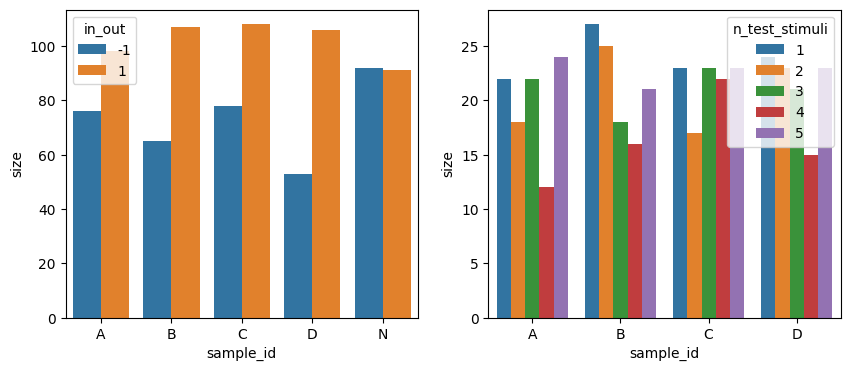

In [173]:
info_task(task)

In [174]:
stim_codes = {'A':'o_1_c_1','B':'o_1_c_5','C':'o_5_c_1','D':'o_5_c_5'}
# kernel parameters

w = 0.015 # seconds = 15 ms
w_size = 0.1 # seconds = 100ms

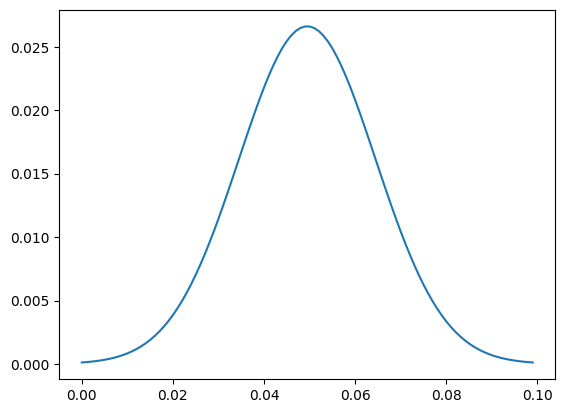

In [175]:
# define kernel for the convolution
kernel = signal.gaussian(M=w_size*config.FS_DS,std=w*config.FS_DS)
kernel=kernel/sum(kernel) # area of the kernel must be one
plt.plot(np.arange(len(kernel))/config.FS_DS,kernel)

In [280]:
events = {
    'start_trial':9,
    'fixation':8,
    'sample_on': 23,
    'sample_off': 24,
    'test_on_1': 25, 
    'test_off_1':26,
    # 'test_on_2': 27, 
    # 'test_off_2':28,
    # 'test_on_3': 29, 
    # 'test_off_3':30,
    # 'test_on_4': 31, 
    # 'test_off_4':32,
    # 'test_on_5': 33, 
    # 'test_off_5':34,
    'end_trial':18,
}

#### Check sample selectiviy


In [299]:
def fr_between_events(neuron_trials,kernel,x_lim_min,x_lim_max,fs,down_sample,shift_events):
    if len(neuron_trials[0]) != 0:
        # Compute trial average fr
        trial_average_sp,sorted_sp_neuron = firing_rate.trial_average_fr(neuron_trials)    

          
        # Downsample to 1ms
        trial_average_sp =np.sum(np.concatenate((trial_average_sp,np.zeros(down_sample-len(trial_average_sp)%down_sample))).reshape(-1,down_sample),axis=1)
    else:
        trial_average_sp=[0]*int((x_lim_max-x_lim_min)*fs)
        sorted_sp_neuron=[int(x_lim_min*fs*down_sample)]
    
    mean_ev = np.mean(shift_events,axis=0)

    if mean_ev[0] < sorted_sp_neuron[0]:#> x_lim_min*fs*down_sample:
        add_zeros = np.zeros(int(sorted_sp_neuron[0]-(x_lim_min*fs*down_sample)))
        conv = np.concatenate((add_zeros,conv))
    else: 
        conv = conv[int(abs(x_lim_min*fs*down_sample)):]
    
    if sorted_sp_neuron[-1]< x_lim_max*fs*down_sample:
        add_zeros = np.zeros(int((x_lim_max*fs*down_sample)-sorted_sp_neuron[-1]))
        conv = np.concatenate((conv,add_zeros))
    
    conv = np.convolve(trial_average_sp,kernel,mode='same')*fs
    return conv,trial_average_sp, sorted_sp_neuron

In [300]:
palette={'A': 'firebrick', 'B': 'teal', 'C': 'tomato', 'D': 'turquoise', 'N': 'grey'}

In [301]:
def mean_fr_by_sample(sp_py,task,events,neurons,in_out,x_lim_min,x_lim_max,fs,down_sample=1,plot=True):
    fs = fs/down_sample
    mean_fr:Dict[str,list] = defaultdict(list)
    
    for i,neuron in enumerate(neurons):
        total_events_timestamps = np.zeros((1,len(events))) 
        conv_max=0
        fig,ax = plt.subplots(figsize=(10, 3),sharex=True,sharey=True)
        for sample in ['A','B','C','D','N']:
            target_trials_idx = task[(task['sample_id']==sample) & (task['in_out']==in_out)]['idx_trial'].values
            events_timestamps = firing_rate.select_events_timestamps(sp_py,target_trials_idx, events) # select events timestamps for all trials
            neuron_trials = firing_rate.align_neuron_spikes(target_trials_idx, sp_py, neuron, events_timestamps[:,2]) # aligne neuron spikes with event
            shift_events = (events_timestamps.T-events_timestamps.T[2]).T
            total_events_timestamps = np.concatenate((total_events_timestamps,shift_events))
            conv,trial_average_sp, sorted_sp_neuron = fr_between_events(neuron_trials,kernel,x_lim_min,x_lim_max,fs,down_sample,shift_events)
            #conv = np.convolve(trial_average_sp,kernel,mode='same')*fs
            conv_max=conv_max if conv_max > max(conv) else max(conv)









            # add values to dict
            ev = np.floor(np.mean(shift_events-sorted_sp_neuron[0],axis=0)/down_sample)
            ev_a = np.zeros(len(conv))
            ev_a[ev.tolist()]=1
            mean_fr['neuron'] += [i+1] * len(conv)
            mean_fr['conv'] += conv.tolist()
            mean_fr['mean_idx_events'] += ev_a.tolist()
            mean_fr['sample'] += [sample] * len(conv)
            if plot:
                ax.plot((np.arange(len(conv)) + x_lim_min*fs) / fs, conv,palette[sample])
        if plot:
            mean_idx_events = total_events_timestamps[2:].mean(axis=0)/down_sample
            ax.vlines(mean_idx_events[0]/fs, 0, conv_max ,color="slategray", linestyles="solid")
            ax.vlines(mean_idx_events[1]/fs, 0, conv_max ,color="slategray", linestyles="dotted")
            ax.vlines(mean_idx_events[2]/fs, 0, conv_max ,color="k", linestyles="solid")
            ax.vlines(mean_idx_events[-1]/fs, 0, conv_max ,color="slategray", linestyles="solid")
            ax.vlines(mean_idx_events[3]/fs, 0, conv_max ,color="silver", linestyles="dashed")
            for n in range(4,len(events)-1,2):
                ax.vlines(mean_idx_events[n]/fs, 0, conv_max ,color="dimgray", linestyles="solid")
                ax.vlines(mean_idx_events[n+1]/fs, 0, conv_max ,color="silver", linestyles="dashed")
            ax.set_title('sample: %s  in_out: %d'%(sample,in_out))
            ax.set_xlim(x_lim_min, x_lim_max)
            fig.legend(['A','B','C','D','N','start_trial','Fixation','Sample on','end_trial','Off','On'], fontsize=9)
            fig.suptitle("Neuron %d" % (i + 1), x=0)
            plt.show()
            
    mean_fr_df=pd.DataFrame(mean_fr)
    return mean_fr_df


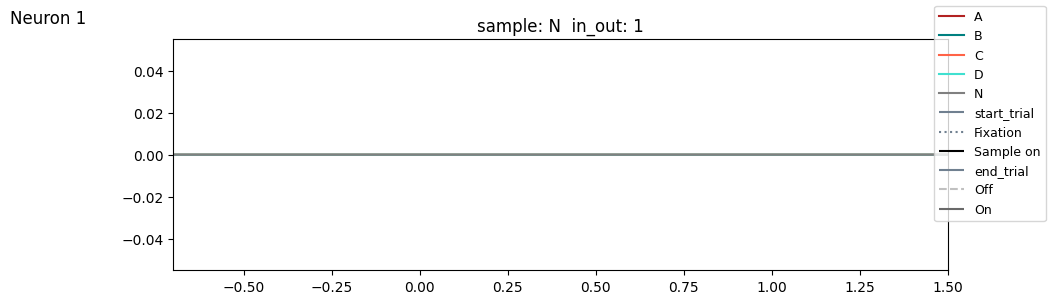

ValueError: max() arg is an empty sequence

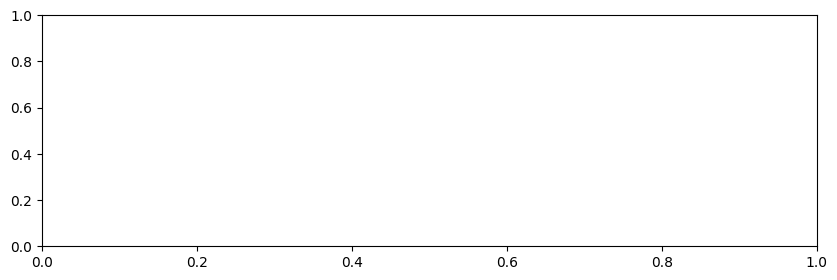

In [302]:
x_lim_max = 1.5
x_lim_min = -0.7
neurons = np.where(sp_py['clustersgroup']=='good')[0]
n_test_stim = 2
code = 2
in_out=1
mean_fr_df = mean_fr_by_sample(sp_py,task,events,neurons,in_out,x_lim_min,x_lim_max,fs=config.FS,down_sample=config.DOWNSAMPLE)

F_onewayResult(statistic=203.79712543668677, pvalue=1.1465519158144797e-149)


/home/INT/losada.c/.virtualenvs/EphysVibe-48n-7Gof/lib/python3.8/site-packages/bioinfokit/analys.py:402: FutureWarning: The default value of numeric_only in DataFrame.mean is deprecated. In a future version, it will default to False. In addition, specifying 'numeric_only=None' is deprecated. Select only valid columns or specify the value of numeric_only to silence this warning.
  mult_group[ele] = df[df[xfac_var] == ele].mean().loc[res_var]


,group1,group2,Diff,Lower,Upper,q-value,p-value
0,A,B,0.231935,0.098878,0.364991,6.729706,0.001
1,A,C,0.885178,0.752122,1.018235,25.683921,0.001
2,A,D,0.672017,0.538960,0.805073,19.498915,0.001
3,A,N,1.221323,1.088266,1.354380,35.437329,0.001
4,B,C,0.653244,0.520260,0.786228,18.964559,0.001
5,B,D,0.440082,0.307098,0.573066,12.776178,0.001
6,B,N,0.989388,0.856404,1.122373,28.723289,0.001
7,C,D,0.213162,0.080178,0.346146,6.188381,0.001
8,C,N,0.336144,0.203160,0.469129,9.758730,0.001
9,D,N,0.549306,0.416322,0.682291,15.947111,0.001


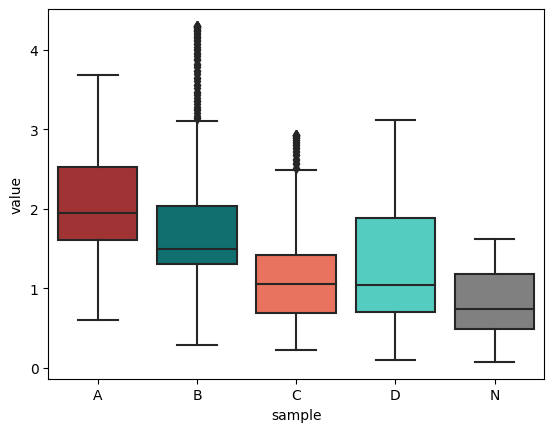

In [285]:
n_neuron = 2
anova_df = mean_fr_df[mean_fr_df['neuron']==n_neuron][['sample','conv','mean_idx_events']].reset_index(drop=True).reset_index()
df:Dict[str,list] = defaultdict(list)

for n_sample in ['A','B','C','D','N']: 
    a_df=anova_df[anova_df['sample']==n_sample].reset_index(drop=True)
    
    # idx events
    a_ev_idx = a_df.index[a_df['mean_idx_events']!=0].values 
    
    # conv between during sample presentation
    a_event = a_df['conv'].values[a_ev_idx[2]:a_ev_idx[3]]
    
    df['sample'] +=[n_sample] * (len(a_event))
    df['value'] +=a_event.tolist()
df = pd.DataFrame(df)
sns.boxplot(x='sample',y='value',data=df,palette=palette)
a_all = df[df['sample']=='A']['value'].values
b_all = df[df['sample']=='B']['value'].values
c_all = df[df['sample']=='C']['value'].values
d_all = df[df['sample']=='D']['value'].values
n_all = df[df['sample']=='N']['value'].values
print(stats.f_oneway(a_all,b_all,c_all,d_all,n_all))
res = bk_stat()
res.tukey_hsd(df=df, res_var='value',xfac_var='sample',anova_model='value~C(sample)')
res.tukey_summary


### Stimuli

In [ ]:
#def get_mean_fr(task,events,neurons,code,n_test_stim,in_out,x_lim_min,x_lim_max,down_sample,sp_py):
total_events_timestamps = np.zeros((1,len(events))) #np.zeros((1,(n_test_stim*2)+3))
mean_fr:Dict[str,list] = defaultdict(list)
for i,neuron in enumerate(neurons):
    conv_max=0
    fig,ax = plt.subplots(figsize=(10, 3),sharex=True,sharey=True)
    for color,sample,stim in zip(['m','c','r','b'],['A','A','A','A'],['A','B','C','D']):#'A','A','A','A'  'B','B','B','B'  'C','C','C','C'  'D','D','D', 'D'
        target_trials_idx = task[(task['sample_id']==sample) & (task['in_out']==in_out) & (task['n_test_stimuli']<7) & (task['test_stimuli_1']==stim_codes[stim])]['idx_trial'].values
        events_timestamps = firing_rate.select_events_timestamps(sp_py,target_trials_idx, events) # select events timestamps for all trials
        neuron_trials = firing_rate.align_neuron_spikes(target_trials_idx, sp_py, neuron, events_timestamps[:,1]) 
        shift_events = (events_timestamps.T-events_timestamps.T[1]).T
        total_events_timestamps = np.concatenate((total_events_timestamps,shift_events))
        trial_average_sp, sorted_sp_neuron = fr_between_events(neuron_trials,x_lim_min,x_lim_max,fs,down_sample)
        conv = np.convolve(trial_average_sp,kernel,mode='same')*fs
        conv_max=conv_max if conv_max > max(conv) else max(conv)
        # add values to dict
        ev = np.floor(np.mean((shift_events.T-shift_events.T[0]).T,axis=0)/down_sample)
        ev_a = np.zeros(len(conv))
        ev_a[ev.tolist()]=1
        mean_fr['neuron'] += [i+1] * len(conv)
        mean_fr['conv'] += conv.tolist()
        mean_fr['mean_idx_events'] += ev_a.tolist()
        mean_fr['sample'] += [sample] * len(conv)
        mean_fr['stim'] += [stim] * len(conv)
        mean_fr['n_test_stimuli'] += [n_test_stim] * len(conv)
        # plot
        ax.plot((np.arange(len(trial_average_sp)) + x_lim_min*fs) / fs, conv,color)

    mean_idx_events = total_events_timestamps[1:].mean(axis=0)/down_sample
    ax.vlines(mean_idx_events[0]/fs, 0, conv_max ,color="g", linestyles="solid")
    ax.vlines(mean_idx_events[1]/fs, 0, conv_max ,color="r", linestyles="dashed")
    ax.vlines(mean_idx_events[2]/fs, 0, conv_max ,color="k", linestyles="solid")
    for n in range(3,len(events),2):
        ax.vlines(mean_idx_events[n]/fs, 0, conv_max ,color="b", linestyles="dashed")
        ax.vlines(mean_idx_events[n+1]/fs, 0, conv_max ,color="k", linestyles="solid")
    
    ax.set_title('sample: %s  in_out: %d'%(sample,in_out))
    ax.set_xlim(x_lim_min, x_lim_max)
    fig.legend(['Stim A','Stim B','Stim C','Stim D','Fixation','Sample on','Off','On'], fontsize=9)
    fig.suptitle("Neuron %d" % (i + 1), x=0)
    plt.show()
mean_fr=pd.DataFrame(mean_fr)


In [ ]:
n_neuron = 8
anova_table = mean_fr[mean_fr['neuron']==n_neuron][['sample','stim','conv','mean_idx_events']].reset_index(drop=True).reset_index()

In [ ]:
df:Dict[str,list] = defaultdict(list)

for n_sample in ['A','B','C','D','N']: 
    a=anova_table[np.logical_and(anova_table['stim']=='A',anova_table['sample']==n_sample)].reset_index(drop=True)
    b=anova_table[np.logical_and(anova_table['stim']=='B',anova_table['sample']==n_sample)].reset_index(drop=True)
    c=anova_table[np.logical_and(anova_table['stim']=='C',anova_table['sample']==n_sample)].reset_index(drop=True)
    d=anova_table[np.logical_and(anova_table['stim']=='D',anova_table['sample']==n_sample)].reset_index(drop=True)
    # idx events
    a_ev_idx = a.index[a['mean_idx_events']!=0].values 
    B_ev_idx = b.index[b['mean_idx_events']!=0].values
    C_ev_idx = c.index[c['mean_idx_events']!=0].values
    D_ev_idx = d.index[d['mean_idx_events']!=0].values
    # conv between during sample presentation
    a_event = a['conv'].values[a_ev_idx[1]:a_ev_idx[2]]
    b_event = b['conv'].values[B_ev_idx[1]:B_ev_idx[2]]
    c_event = c['conv'].values[C_ev_idx[1]:C_ev_idx[2]]
    d_event = d['conv'].values[D_ev_idx[1]:D_ev_idx[2]]

    df['color'] += np.concatenate((['c1']*len(a_event),['c5']*len(b_event),['c1']*len(c_event),['c5']*len(d_event)),dtype=str).tolist()
    df['orientation'] +=np.concatenate((['o1']*len(a_event),['o1']*len(b_event),['o5']*len(c_event),['o5']*len(d_event)),dtype=str).tolist()
    df['sample'] +=[n_sample] * (len(a_event)+len(b_event)+len(c_event)+len(d_event))
    df['value'] +=np.concatenate((a_event,b_event,c_event,d_event)).tolist()


In [ ]:
df = pd.DataFrame(df)

In [ ]:
sns.boxplot(x='sample',y='value',data=df)#,hue='orientation'

In [ ]:
a_all = df[df['sample']=='A']['value'].values
b_all = df[df['sample']=='B']['value'].values
c_all = df[df['sample']=='C']['value'].values
d_all = df[df['sample']=='D']['value'].values

stats.f_oneway(a_all,b_all,c_all,d_all)

In [ ]:
res = bk_stat()
res.tukey_hsd(df=df, res_var='value',xfac_var='sample',anova_model='value~C(sample)')
res.tukey_summary

In [ ]:
model_str = 'value ~ C(color)+C(orientation)+C(sample) + C(color):C(orientation):C(sample)'
model = ols(model_str, data = df).fit()

In [ ]:
anova_res = sm.stats.anova_lm(model,type=2)

In [ ]:
anova_res

### Post-hoc

In [ ]:
res = bk_stat()

In [ ]:
res.tukey_hsd(df=df, res_var='value',xfac_var='color',anova_model=model_str)
res.tukey_summary

In [ ]:
res.tukey_hsd(df=df, res_var='value',xfac_var='orientation',anova_model=model_str)
res.tukey_summary

In [ ]:
res.tukey_hsd(df=df, res_var='value',xfac_var='sample',anova_model=model_str)
res.tukey_summary

In [ ]:
res.tukey_hsd(df=df, res_var='value',xfac_var=['sample','color'],anova_model=model_str)
a=res.tukey_summary
a

In [ ]:
res.tukey_hsd(df=df, res_var='value',xfac_var=['sample','orientation'],anova_model=model_str)
a=res.tukey_summary
a

In [ ]:
res.tukey_hsd(df=df, res_var='value',xfac_var=['sample','orientation','color'],anova_model=model_str)
a=res.tukey_summary
a.head(20)

### ROC

In [ ]:
# ROC AUC score
roc = []
a_df = df[(df['sample']=='A')]
b_df = df[(df['sample']=='D')]
for i in range(len(a_df)-100):
    y_a = a_df['sample'].replace(['A'],[0]).values[i:i+100]
    y_b = b_df['sample'].replace(['D'],[1]).values[i:i+100]
    y = np.concatenate((y_a,y_b))

    x = np.concatenate((a_df['value'].values[i:i+100],b_df['value'].values[i:i+100]))
    x=np.array([x]).T
    clf = LogisticRegression(solver='liblinear',random_state=2022).fit(x,y)
    roc.append(roc_auc_score(y,clf.decision_function(x)))
plt.plot(roc)